Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7275 - loss: 0.1490 - val_accuracy: 0.7613 - val_loss: 0.0958
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7732 - loss: 0.0902 - val_accuracy: 0.7734 - val_loss: 0.0864
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7926 - loss: 0.0695 - val_accuracy: 0.7808 - val_loss: 0.0880
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8390 - loss: 0.0490 - val_accuracy: 0.7778 - val_loss: 0.1005
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8881 - loss: 0.0316 - val_accuracy: 0.7673 - val_loss: 0.1076
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


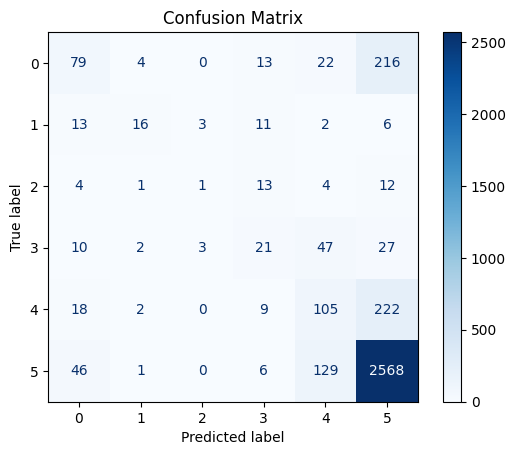


Accuracy: 0.7673
Precision (macro): 0.4487
Recall (macro): 0.3331

Classification Report:
              precision    recall  f1-score   support

           0     0.4647    0.2365    0.3135       334
           1     0.6154    0.3137    0.4156        51
           2     0.1429    0.0286    0.0476        35
           3     0.2877    0.1909    0.2295       110
           4     0.3398    0.2949    0.3158       356
           5     0.8417    0.9338    0.8854      2750

    accuracy                         0.7673      3636
   macro avg     0.4487    0.3331    0.3679      3636
weighted avg     0.7313    0.7673    0.7426      3636



In [1]:
# focal loss 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")

columns_to_drop = [
    'recipe_number', 'recipe_code', 'recipe_name',
    'comment_id', 'user_id', 'user_name', 'created_at'
]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.dropna(subset=['text'])

texts = df_cleaned['text'].astype(str).values
labels = df_cleaned['stars'].values
numeric_features = df_cleaned[['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']]

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    text_padded, numeric_features_scaled, labels, test_size=0.2, random_state=42)

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
x = Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH)(text_input)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

numeric_input = Input(shape=(X_num_train.shape[1],), name='numeric_input')
y = Dense(64, activation='relu')(numeric_input)

combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[text_input, numeric_input], outputs=z)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

history = model.fit(
    [X_text_train, X_num_train], y_train_cat,
    validation_data=([X_text_test, X_num_test], y_test_cat),
    epochs=5,
    batch_size=32
)

y_pred_probs = model.predict([X_text_test, X_num_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision (macro): {precision:.4f}")

recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall (macro): {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))